<a href="https://colab.research.google.com/github/antonioenas/Denoising_HPatches_for_Descriptor_Learning/blob/master/1_baseline_denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Baseline denoiser - Deep learning coursework, Imperial College London
**Antonio Enas, 01070859, AE1115**


---

In this notebook, the user can generate and train the baseline denoiser model.

Structure:
1. Environment set up
2. Define model
3. Training up to 1 epoch
4. Full training

# 1. Environment set up
This section ensures all libraries and dataset are correctly imported.

If data is already mounted select:
              `import_data = False`

In [0]:
import_data = False

### Optional GPU check

In [0]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

### Cloning the repository and downloading the data

In [4]:
if import_data == False:
  # Change directory
  %cd /content/keras_triplet_descriptor
else:
  # Clone repo
  !git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor
  %cd /content/keras_triplet_descriptor
  # Download data
  !wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
  # Extract data
  !unzip -q ./hpatches_data.zip
  !rm ./hpatches_data.zip


/content/keras_triplet_descriptor


### Importing Necessary Modules

In [0]:
!pip install -U seaborn

import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams["patch.force_edgecolor"] = True

# To download files
from google.colab import files

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


# 2. Define model
In this section the baseline mode, generator data and compiler are defined.

The baseline mode consists of a shallow U-Net.

In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net


There are 76 sequences in the train set. To speed up training, only a portion can be used. It is suggested to use the entire dataset after the first epoch of training onto the smaller sample.

In [0]:
sequences_train = 3;            # over 76
batch_size_gen_denoiser = 50;   # above 200 is not feasable in terms of RAM

In [13]:
# Train sequence generator
if sequences_train < 76:
  denoise_generator = DenoiseHPatches(random.sample(seqs_train, sequences_train), batch_size=50)
elif sequences_train == 76:
  denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)

# Validation sequence generator
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 40/40 [00:42<00:00,  1.23it/s]


The baseline optimiser is SGD. However, Adam provides faster convergence to a smaller MAE. To run the code and save the baseline model obtained with either of the two, please select the `optimiser_name` variable to be either `'sgd'` or `'adam'`.

In [0]:
optimiser_name = 'adam'

In [0]:
# Random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Input shape
ip_shape = (32,32,1)

# Compile model
denoise_model = get_denoise_model(ip_shape)
denoise_model.compile(loss='mean_absolute_error', optimizer=optimiser_name)


Print the model summary.

In [16]:
denoise_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 16)   160         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 16)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 16, 16, 32)   4640        max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
up_samplin

# 3. Training up to 1 epoch
A single epoch of training constitutes the actual baseline denoiser model. Click on the link to the remote host to download the saved model.

In [17]:
# Train model with adam
baseline_denoiser_history = denoise_model.fit_generator(
                                              generator=denoise_generator,
                                              epochs=1,
                                              verbose=1,
                                              validation_data=denoise_generator_val)


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1275/1275 [==============================] - 179s 140ms/step - loss: 7.3350 - val_loss: 6.1207


Save the model for future use in the evaluation section.

In [18]:
# Save model
denoise_model.save('bs_denoiser_1e.h5') 
# Upload model
!curl -F "file=@bs_denoiser_1e.h5" https://file.io

{"success":true,"key":"jWdIOA","link":"https://file.io/jWdIOA","expiry":"14 days"}

In [0]:
bs_den_loss = baseline_denoiser_history.history['loss']
bs_den_val_loss = baseline_denoiser_history.history['val_loss']

# 4. Full training
In this section the baseline denoiser model is trained until convergence for further comparison with the improved proposed solution. 10 epochs in total is the standard length chosen to display learning curve behaviour but it is modifiable through the parameter `full_training_epochs`.

In [0]:
full_training_epochs = 10

In [21]:
denoise_history = denoise_model.fit_generator(generator=denoise_generator, 
                                                epochs=full_training_epochs-1, verbose=1, 
                                                validation_data=denoise_generator_val)


Epoch 1/9
1275/1275 [==============================] - 176s 138ms/step - loss: 5.5725 - val_loss: 5.7245
Epoch 2/9
1275/1275 [==============================] - 177s 139ms/step - loss: 5.3947 - val_loss: 5.6331
Epoch 3/9
1275/1275 [==============================] - 176s 138ms/step - loss: 5.2538 - val_loss: 5.6278
Epoch 4/9
1275/1275 [==============================] - 178s 140ms/step - loss: 5.1921 - val_loss: 5.5124
Epoch 5/9
1275/1275 [==============================] - 173s 136ms/step - loss: 5.1099 - val_loss: 5.5620
Epoch 6/9
1275/1275 [==============================] - 174s 136ms/step - loss: 5.0743 - val_loss: 5.4326
Epoch 7/9
1275/1275 [==============================] - 173s 136ms/step - loss: 5.0385 - val_loss: 5.4781
Epoch 8/9
1275/1275 [==============================] - 175s 137ms/step - loss: 4.9959 - val_loss: 5.4026
Epoch 9/9
1275/1275 [==============================] - 174s 137ms/step - loss: 4.9803 - val_loss: 5.5077


Save the model after 10 epochs of training.

In [22]:
# Save model
denoise_model.save('bs_denoiser_10e.h5') 
# Upload model
!curl -F "file=@bs_denoiser_10e.h5" https://file.io

{"success":true,"key":"YzqssW","link":"https://file.io/YzqssW","expiry":"14 days"}

In [0]:
bs_den_loss.extend(baseline_denoiser_history.history['loss'])
bs_den_val_loss.extend(baseline_denoiser_history.history['val_loss'])

Plot learning curves.

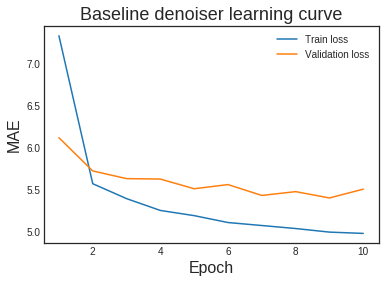

In [8]:
# Mean absolute error
plt.plot(np.arange(1,11), bs_den_loss)
plt.plot(np.arange(1,11), bs_den_val_loss)

plt.title('Baseline denoiser learning curve', fontsize = 18)
plt.ylabel('MAE', fontsize = 16)
plt.xlabel('Epoch', fontsize = 16)
plt.legend(['Train loss','Validation loss'])